In [15]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [16]:

train_dir = '..//train/'
test_dir = '..//test/'



IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [17]:


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [18]:

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

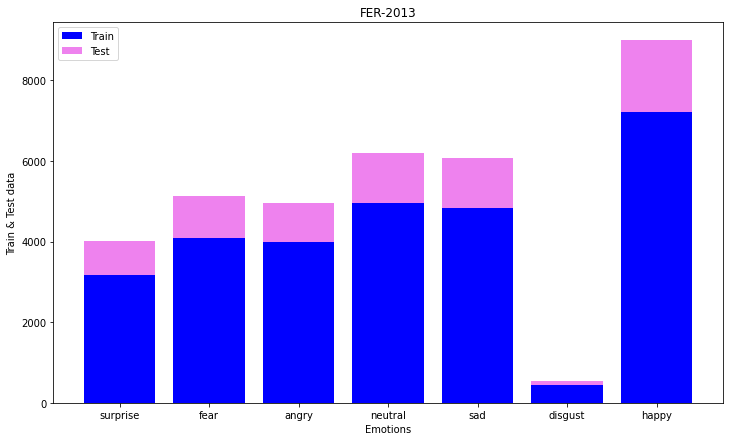

In [22]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

In [24]:
# VGG16

base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [25]:
# Freezing Layers

for layer in base_model.layers[:11]:
    layer.trainable=False

In [26]:
# Model trainable

print("Model trainable",len(model.trainable_variables))

Model trainable 22


In [27]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1, 512)         2048      
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

In [28]:

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [29]:

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)


Epoch 1/100
449/449 [==============================] - 65s 140ms/step - loss: 5.2423 - accuracy: 0.8181 - precision: 0.2100 - recall: 0.0990 - auc: 0.5575 - f1_score: 0.1343 - val_loss: 9.4883 - val_accuracy: 0.8028 - val_precision: 0.3098 - val_recall: 0.3098 - val_auc: 0.5762 - val_f1_score: 0.3120
Epoch 2/100
449/449 [==============================] - 67s 150ms/step - loss: 4.5363 - accuracy: 0.8350 - precision: 0.3168 - recall: 0.1340 - auc: 0.6223 - f1_score: 0.1875 - val_loss: 2.9174 - val_accuracy: 0.8518 - val_precision: 0.4151 - val_recall: 0.0913 - val_auc: 0.5567 - val_f1_score: 0.1485
Epoch 3/100
449/449 [==============================] - 62s 138ms/step - loss: 4.1484 - accuracy: 0.8460 - precision: 0.4027 - recall: 0.1608 - auc: 0.6693 - f1_score: 0.2290 - val_loss: 4.9919 - val_accuracy: 0.8248 - val_precision: 0.3705 - val_recall: 0.3239 - val_auc: 0.6357 - val_f1_score: 0.3460
Epoch 4/100
449/449 [==============================] - 63s 139ms/step - loss: 3.7984 - accurac

In [30]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

113/113 [==============================] - 7s 64ms/step - loss: 1.4052 - accuracy: 0.9021 - precision: 0.6669 - recall: 0.6289 - auc: 0.9031 - f1_score: 0.6465


In [33]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

Confusion matrix, without normalization

[[153   9 131 247 168 149 101]
 [ 23   1  10  22  20  19  16]
 [149  13 132 246 187 176 121]
 [231  30 233 409 360 332 179]
 [183  13 128 304 250 198 157]
 [174  18 169 282 222 222 160]
 [121  12  95 242 138 139  84]]





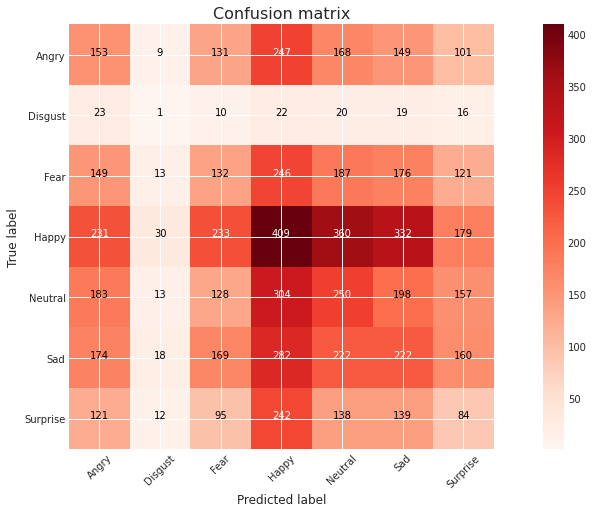

In [34]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")